In [6]:
# 데이터 처리
import pandas as pd
import numpy as np

# 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 기타
from datetime import datetime

### 주문 방치 (주문 접수 후 7일 이상 출고 안된 것)

##### 데이터 가져오기 

In [7]:
# 주문 메인 데이터 
orders = pd.read_csv('olist_orders_dataset.csv')

# 주문 상세 데이터 
order_items = pd.read_csv('olist_order_items_dataset.csv')

# 리뷰 데이터 
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

##### 날짜 형식 변환 

In [8]:
# 날짜 관련 컬럼 리스트
date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]

# 모든 날짜 컬럼을 한 번에 변환
for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

In [9]:
# 필터링 전 실제 데이터의 전체 기간 확인
print("전체 데이터 시작일:", orders['order_purchase_timestamp'].min())
print("전체 데이터 종료일:", orders['order_purchase_timestamp'].max())

전체 데이터 시작일: 2016-09-04 21:15:00
전체 데이터 종료일: 2018-10-17 17:30:00


##### 2017년 1월 ~ 2018년 9월 데이터만 필터링

In [12]:
# 필터링 전 건수
original_count = len(orders)

# 2017년 1월 ~ 2018년 9월 데이터 필터링
orders = orders.query("order_purchase_timestamp >= '2017-01-01' and order_purchase_timestamp <= '2018-09-30'")

# 필터링 후 건수 저장
filtered_count = len(orders)

# 4. 결과 출력
print(f"필터링 전 주문 건수: {original_count:,}건")
print(f"필터링 후 주문 건수: {filtered_count:,}건")
print(f"제외된 주문 건수: {original_count - filtered_count:,}건")
print(f"데이터 기간: {orders['order_purchase_timestamp'].min()} ~ {orders['order_purchase_timestamp'].max()}")

필터링 전 주문 건수: 99,108건
필터링 후 주문 건수: 99,108건
제외된 주문 건수: 0건
데이터 기간: 2017-01-05 11:56:00 ~ 2018-09-29 09:13:00


##### 기초 통계 확인 

In [13]:
# 결제 승인 후 택배사 인도까지 걸린 시간(일 단위) 계산
# 결측치는 제외하고 계산
orders['lead_time_days'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days

# 전체적인 분포 확인
lead_time_stats = orders['lead_time_days'].describe()
print("[출고 소요 기간 통계]")
print(lead_time_stats)

[출고 소요 기간 통계]
count    97363.000000
mean         2.271582
std          3.469835
min       -172.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: lead_time_days, dtype: float64


In [39]:
# 정상적 출고 :  97644
# 평균 = 2~3일정도 출고 
# 전체 주문 중 50%은 하루만에 출고됨
# Min값 -이유 = 데이터 오류 (승인 안된 주문을 보냈다고 기록함 or 시스템 오류 or 가송장)

In [15]:
# 컬럼별 결측치 개수 확인
missing_values = orders.isnull().sum()
print("[컬럼별 결측치]")
print(missing_values)

# 전체 대비 결측치 비율(%) 확인
print("\n[결측치 비율]")
print((missing_values / len(orders)) * 100)

[컬럼별 결측치]
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 150
order_delivered_carrier_date     1731
order_delivered_customer_date    2904
order_estimated_delivery_date       0
lead_time_days                   1745
dtype: int64

[결측치 비율]
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.151350
order_delivered_carrier_date     1.746579
order_delivered_customer_date    2.930137
order_estimated_delivery_date    0.000000
lead_time_days                   1.760705
dtype: float64


In [16]:
# order_delivered_carrier_date = 결제 완료 + 판매자가 물류사에 물건 안넘김
# order_delivered_customer_date = 고객이 물건을 받지 못함 (미출고 방치 + 배송중 + 분실건)

##### 데이터 정제 

In [17]:
# 출고가 완료된 건 (정상/지연 배송 분석용)
# carrier_date가 있는 데이터만 사용
shipment_completed = orders[orders['order_delivered_carrier_date'].notna()].copy()

# 출고가 안 된 건 (미출고 방치 주문 분석용)
# carrier_date가 없는 데이터만 사용
shipment_pending = orders[orders['order_delivered_carrier_date'].isnull()].copy()

print(f"현재 미출고 상태인 주문: {len(shipment_pending)}건")

현재 미출고 상태인 주문: 1731건


##### 7일 기준 _ 통계적 근거 

In [18]:
# 정상 출고 건의 소요 일수 계산
shipment_completed['lead_time_days'] = (
    shipment_completed['order_delivered_carrier_date'] - shipment_completed['order_approved_at']
).dt.days

# 백분위 확인 (90%, 95%, 99%)
percentiles = shipment_completed['lead_time_days'].quantile([0.9, 0.95, 0.99])
print("[출고 소요 기간 백분위]")
print(percentiles)

[출고 소요 기간 백분위]
0.90     5.0
0.95     8.0
0.99    16.0
Name: lead_time_days, dtype: float64


In [19]:
# 대다수 판매자 (90%) = 5일 이내 출고함 = 판매자 90%가 결제 후, 5일 안에 택배사에 물건 넘김 
# 95% = 8일 / 7~8일 사이는 5%만 속함 


# 6일로 하지 않은 이유 
# 금요일 오후에 주문하고 월욜이 공휴이인 경우 = 달력상 6일이 지남
# (금-주문 / 토일-주말 / 월-휴일 / 화수목-영업일 3일)


# 7일 일 경우, 어떤 요일에 주문하더라도 주말을 반드시 한 번만 포함하게 됨 
# 대부분 정상 판매자 (90이상)가 업무를 마치고, 이를 넘기는 순간 상위5% 미만의 심각한 지연으로 분류되는 임계점 

##### 주문 방치 건 추출 _1206건

In [20]:
# 데이터상의 최신 날짜를 '현재' 기준으로 설정
current_reference_date = orders['order_purchase_timestamp'].max() 

# 방치 주문 필터링 조건 설정
long_delayed_shipment = orders[
    (orders['order_status'] != 'canceled') &                # 1) 취소되지 않은 주문 중
    (orders['order_delivered_carrier_date'].isna()) &       # 2) 아직 택배사에 인도되지 않았고 (결측치)
    ((current_reference_date - orders['order_purchase_timestamp']).dt.days > 7)  # 3) 주문 후 7일이 경과한 건
].copy()

# 결과 확인
print(f"7일 이상 출고(Carrier Date)가 안 된 건: {len(long_delayed_shipment)}건")

7일 이상 출고(Carrier Date)가 안 된 건: 1206건


##### 7일 이상 방치 주문 상태 분포 (600건 정도 재고부족 = 운영 멈춘 방치상태 아닌가?)

In [21]:
# 기준 시점 설정 (데이터셋 내 마지막 구매일 기준)
current_date = orders['order_purchase_timestamp'].max()

# 7일 이상 방치된 주문 추출 (취소건 제외)
# 아직 택배사에 인도되지 않은(NaN) 주문 중 7일이 경과한 건
abandoned_orders = orders[
    (orders['order_delivered_carrier_date'].isna()) & 
    ((current_date - orders['order_purchase_timestamp']).dt.days >= 7) &
    (orders['order_status'] != 'canceled')
].copy()

# 상태별 분포 확인
status_distribution = abandoned_orders['order_status'].value_counts()
print("[7일 이상 방치 주문 상태 분포]")
print(status_distribution)

[7일 이상 방치 주문 상태 분포]
order_status
unavailable    602
processing     299
invoiced       296
created          5
approved         2
delivered        2
Name: count, dtype: int64


In [22]:
# unavailable - 재고가 없는지 뭔지 모르지만 주문 취소 안함 ( 악성 판매자 아닌가? )
# processing - 실제 물건을 택배사에 안넘김 (운영 미숙, 인력 부족) 등 물류 프로세싱 문제이지 않을까
# invoiced - 송장 발행됨 (물류 사정이거나, 송장만 뽑아두고 재고 확보중인경우 = 가송장)


# 1200여건 중 600건 정도가 재고부족(unavailable)은 운영을 멈춘 방치 상태로 볼수 있지 않을까?

##### 7일 이상 방치된 주문 비중 _ 1.22%

In [25]:
abandoned_ratio = (len(abandoned_orders) / len(orders)) * 100
print(f"해당 기간 내 전체 주문 대비 방치율: {abandoned_ratio:.2f}%")

해당 기간 내 전체 주문 대비 방치율: 1.22%


##### 상습 방치 판매자 

In [23]:
# 방치 주문 데이터와 아이템 데이터를 결합하여 seller_id 확보
abandoned_with_sellers = pd.merge(
    abandoned_orders, 
    order_items[['order_id', 'seller_id', 'price', 'freight_value']], 
    on='order_id', 
    how='left'
)

# 판매자별 방치 건수 계산 및 정렬
seller_fault_counts = abandoned_with_sellers.groupby('seller_id').size().reset_index(name='abandoned_count')
seller_fault_counts = seller_fault_counts.sort_values(by='abandoned_count', ascending=False)

# 상습 방치 판매자 TOP 10의 모든 주문 상세 내역 보기
# 건수가 많은 판매자의 ID 리스트
top_offenders = seller_fault_counts.head(10)['seller_id'].tolist()

# 해당 판매자들의 모든 컬럼 정보를 출력
top_offender_details = abandoned_with_sellers[abandoned_with_sellers['seller_id'].isin(top_offenders)]

# 결과 확인 (주요 컬럼 순서 재배치)
display_cols = [
    'seller_id', 'abandoned_count', 'order_status', 'order_purchase_timestamp', 
    'order_approved_at', 'order_estimated_delivery_date', 'price'
]

top_offender_full_view = pd.merge(top_offender_details, seller_fault_counts, on='seller_id')
top_offender_full_view[display_cols].sort_values(by='abandoned_count', ascending=False)

,seller_id,abandoned_count,order_status,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,price
112,4342d4b2ba6b161468c63a7e7cfce593,18,processing,2018-01-05 23:07:00,2018-01-09 07:18:00,2018-02-06,129.90
62,18a349e75d307f4b4cc646a691ed4216,18,processing,2017-10-17 16:35:00,2017-10-19 02:49:00,2017-11-14,48.00
78,4342d4b2ba6b161468c63a7e7cfce593,18,processing,2018-01-05 11:18:00,2018-01-05 11:27:00,2018-02-09,129.90
76,4342d4b2ba6b161468c63a7e7cfce593,18,processing,2017-12-23 19:00:00,2017-12-23 19:07:00,2018-01-29,129.90
75,4342d4b2ba6b161468c63a7e7cfce593,18,processing,2018-01-01 20:40:00,2018-01-01 20:50:00,2018-02-02,129.90
...,...,...,...,...,...,...,...
29,ffff564a4f9085cd26170f4732393726,8,processing,2017-03-16 14:15:00,2017-03-16 14:15:00,2017-04-28,51.45
30,cc419e0650a3c5ba77189a1882b7556a,8,invoiced,2017-07-25 12:48:00,2017-07-25 16:55:00,2017-08-10,56.99
73,cc419e0650a3c5ba77189a1882b7556a,8,invoiced,2017-10-16 12:21:00,2017-10-18 02:56:00,2017-11-14,89.99
72,cc419e0650a3c5ba77189a1882b7556a,8,invoiced,2017-10-16 12:21:00,2017-10-18 02:56:00,2017-11-14,34.99


##### 월 별 방치 주문 발생 분석 

[월별 방치 주문 발생 건수]
purchase_month  abandoned_count
       2017-01               31
       2017-02               89
       2017-03               58
       2017-04               34
       2017-05               71
       2017-06               47
       2017-07               70
       2017-08               70
       2017-09               78
       2017-10               94
       2017-11              146
       2017-12               92
       2018-01               92
       2018-02               43
       2018-03               49
       2018-04               27
       2018-05               46
       2018-06                7
       2018-07               32
       2018-08               30


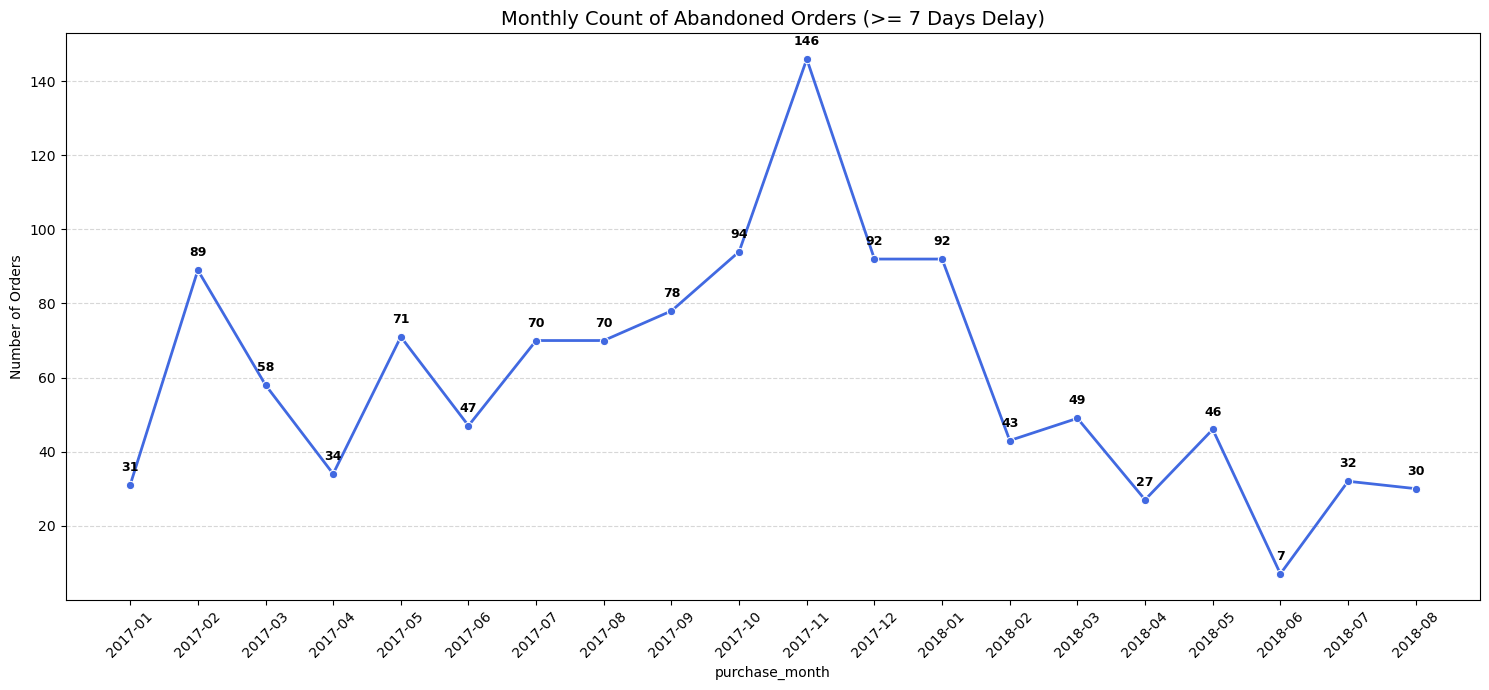

In [28]:
# 월별 방치 건수 집계 및 정렬
monthly_abandoned = abandoned_orders.groupby('purchase_month').size().reset_index(name='abandoned_count')
monthly_abandoned['purchase_month'] = monthly_abandoned['purchase_month'].astype(str)

# 월별 수치 리스트 출력
print("[월별 방치 주문 발생 건수]")
print(monthly_abandoned.to_string(index=False))

# 시계열 그래프 (수치 표시 +)
plt.figure(figsize=(15, 7))
ax = sns.lineplot(data=monthly_abandoned, x='purchase_month', y='abandoned_count', marker='o', color='royalblue', linewidth=2)

# 각 점 위에 건수 표시
for i, txt in enumerate(monthly_abandoned['abandoned_count']):
    ax.annotate(txt, (monthly_abandoned['purchase_month'][i], monthly_abandoned['abandoned_count'][i]), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

plt.xticks(rotation=45)
plt.title('Monthly Count of Abandoned Orders (>= 7 Days Delay)', fontsize=14)
plt.ylabel('Number of Orders')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### 특정 기간 방치 주문 상태 분석 

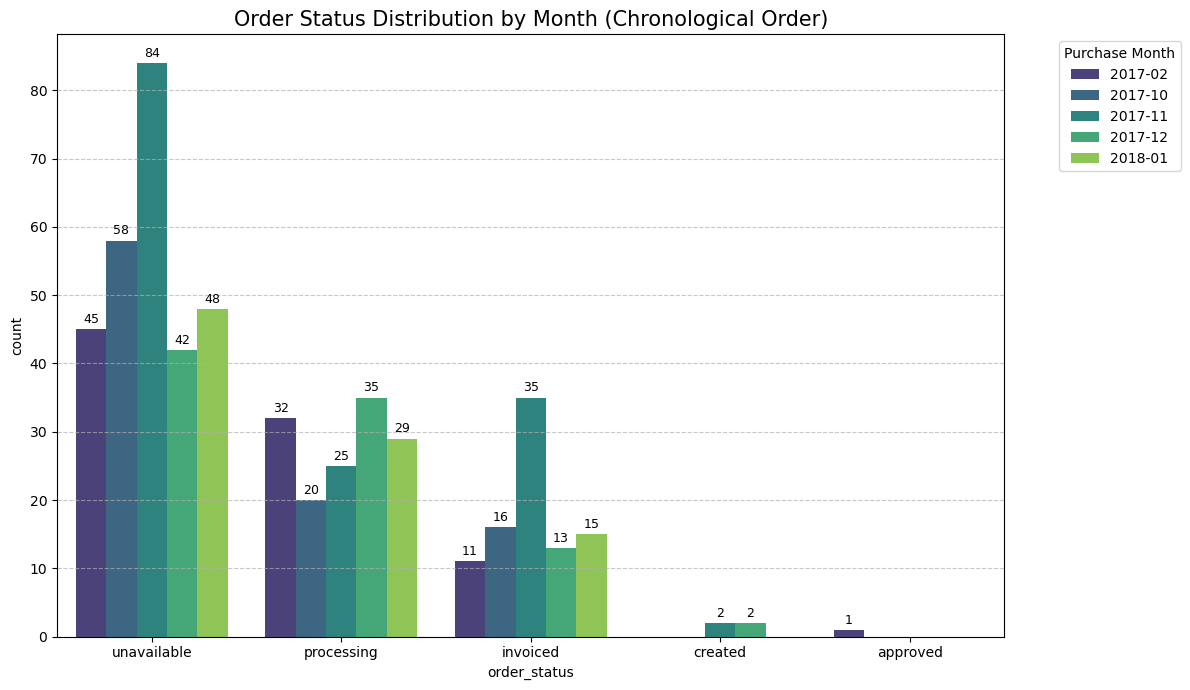

In [34]:
# 1. 분석 대상 기간을 시간 순서대로 정렬
target_months_ordered = ['2017-02', '2017-10', '2017-11', '2017-12', '2018-01']

# 2. 데이터프레임 내 purchase_month를 문자열로 변환하여 필터링 및 정렬 준비
target_abandoned = abandoned_orders[abandoned_orders['purchase_month'].astype(str).isin(target_months_ordered)].copy()
target_abandoned['month_str'] = target_abandoned['purchase_month'].astype(str)

# 3. 시각화
plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=target_abandoned, 
    x='order_status', 
    hue='month_str', 
    hue_order=target_months_ordered, # 여기서 범례와 막대 순서를 강제 지정합니다
    palette='viridis'
)

# 그래프 디테일 설정
plt.title('Order Status Distribution by Month (Chronological Order)', fontsize=15)
plt.legend(title='Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 수치 표시 (선택 사항)
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 7), 
                    textcoords='offset points',
                    fontsize=9)

plt.tight_layout()
plt.show()

In [37]:
# 17년 2월 (약 90건)
# 카니발 시즌 (processing)이라면 주문 확인 후 휴가로 실제 출고 못한 경우나, 그렇게 높지 않음 
# 18년 기준 2월 = 40건 내외임 
# 재고 고갈 사태일 가능성도 있음


# 17년 11월
# 블랙프라이데이 = 수요 폭증 = 제고 관리 실패 (수요 예측 실패) 
# 물건은 없는데 주문만 받은 상태 
# 18년 1월까지 높은 수준으로 유지 

# 17년 12월 
# 주문은 확인 되었으나, 포장&출고 단계로 못넘어감 (= 물리적 인력 부족 or 시스템 과부하) 


# invoiced (송장 발행 완료) ---------> 제외해야할 듯 
# 가송장 or 수거 지연 
# 송장은 뽑았으나, 택배사가 수거하지 못한 상태일수도 있음 

##### 카테고리별 _ 방치 주문 분석 

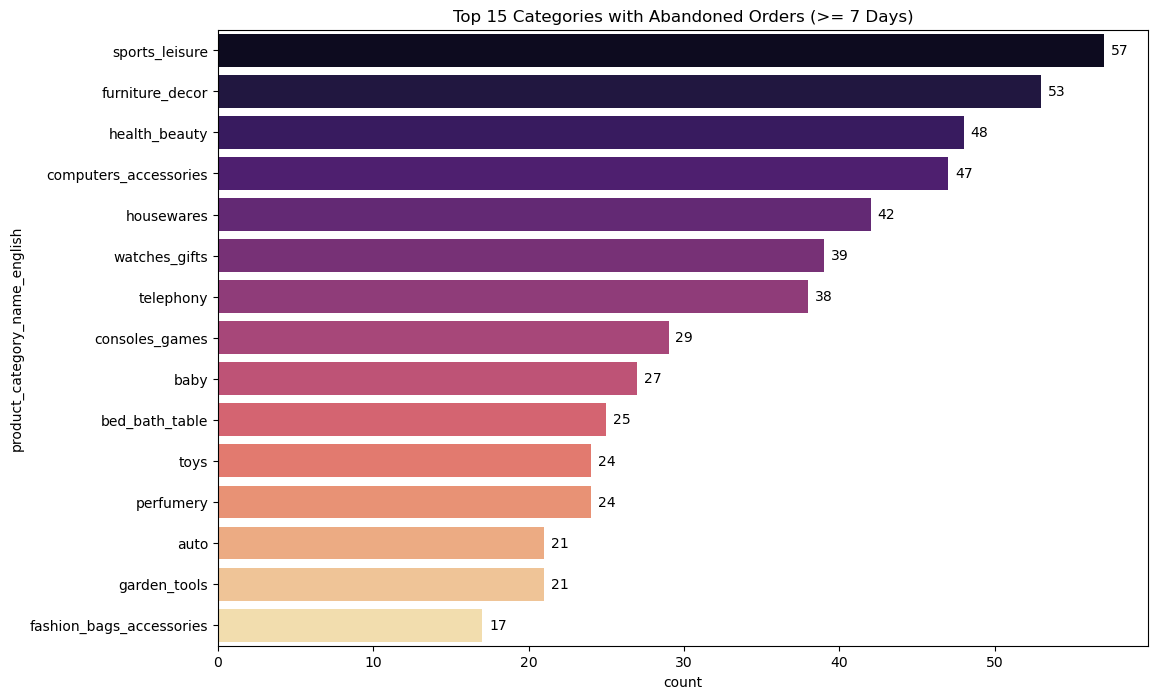

In [24]:
# 데이터 로드 (상품 및 카테고리 번역 데이터)
products = pd.read_csv('olist_products_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

# 7일 이상 방치 주문(abandoned_orders)과 상품 정보 결합
abandoned_items = pd.merge(abandoned_orders, order_items, on='order_id')
abandoned_items = pd.merge(abandoned_items, products[['product_id', 'product_category_name']], on='product_id')
abandoned_items = pd.merge(abandoned_items, category_translation, on='product_category_name')

# 카테고리별 방치 건수 집계
category_analysis = abandoned_items.groupby('product_category_name_english').size().reset_index(name='count')
category_analysis = category_analysis.sort_values(by='count', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=category_analysis.head(15), 
    x='count', 
    y='product_category_name_english', 
    hue='product_category_name_english', 
    palette='magma', 
    legend=False)

# 막대 끝에 숫자 추가
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points')

plt.title('Top 15 Categories with Abandoned Orders (>= 7 Days)')
plt.show()

##### :)